In [1]:
import itertools
import sys, os

import numpy as np
import pandas as pd
from scipy.special import comb
from scipy import stats
import scipy.cluster.hierarchy as hac
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore
sns.set(rc={'figure.figsize':(15,8)})
sns.set_context('poster')

In [2]:
%load_ext autoreload
%autoreload 2
import CCPA_lib as cp


In [3]:
sns.set_context('poster')

In [4]:
pedge = 'green'
apallete = "spring"
aorder = ['DE', 'DE1', '1A3', 'ATCC', 'BS11']
amarkers = ['P', 'X', 'h', '<','>']
apallete = ['#6dad36', '#c7e89f', '#f5c4e1', '#d5579d', '#8a0850']

aedge='orange'
epallete = ['#6cf0ba', '#d13f75', '#eeb7cb', '#b9d2d8', '#407f90']
#sns.diverging_palette(355, 217, s=74, l=50, n=4) #'Paired' # 'BrBG'# "coolwarm"
eorder = ['e1','e3', 'e4', 'e5', 'e6']
#aedge='orange'

espallete = ['#6cf0ba', '#D55282', '#538B9B']

In [231]:
def _parse_csv(i, t):
    idx = 160000+i
    dname = f'D20-{idx}-4500T'
    #glob(os.path.join(data_dpath, dname,'**', '*.csv'), recursive=True)
    flist = glob(os.path.join(data_dpath, dname,'**', f'snp_{t}*.csv'), recursive=True)
    dfs = [pd.read_csv(f) for f in flist]
    if len(dfs):
        df = pd.concat(dfs)
        df['sample_number'] = i
        df['species'] = t
        return df
    else:
        return None

df_list = [_parse_csv(i,t) for i in range(1,22) for t in ['1A3', 'DE', 'MIT9313', 'MIT0604']]
df = pd.concat(df_list)

In [232]:
df.groupby(['species', 'sample_number', ])['TYPE'].count()

species  sample_number
1A3      1                   2
         5                   6
         6                   2
         7                   1
         12                  4
         14                  1
DE       2                 226
         16                159
         17               1905
         18                117
         20               2485
MIT0604  4                  13
         10                  4
         11                 14
         12                  7
         13                 15
         14                 13
         15                 15
         16                  1
         17                 15
         19                 15
         20                  8
         21                 15
MIT9313  3                  74
         5                   9
         6                  49
         7                  35
         9                  67
Name: TYPE, dtype: int64

In [233]:
meta_df = pd.read_excel('exp 6 transfer Apr2019.xlsx', sheet_name='sent for seq')

In [234]:
meta_df.rename(columns={'#': 'sample_number'}, inplace=True)

In [235]:
df = pd.merge(df, meta_df, on='sample_number', how='left')

In [236]:
df.head()

,CHROM,POS,TYPE,REF,ALT_x,EVIDENCE,FTYPE,STRAND,NT_POS,AA_POS,...,PRODUCT,sample_number,species,sample,PRO,ALT_y,exp,days,ng/ul,final volume
0,NZ_CP012202,2467374,complex,CA,TG,TG:31 CA:2,NaN,NaN,NaN,NaN,...,NaN,1,1A3,Axenic,Axenic,1A3,0,0,30,100
1,NZ_CP012202,4168741,snp,N,G,G:30 N:0,CDS,-,857/1170,286/389,...,SO_0444 family Cu/Zn efflux transporter,1,1A3,Axenic,Axenic,1A3,0,0,30,100
2,NC_011138,7070,ins,G,GT,GT:18 G:0,NaN,NaN,NaN,NaN,...,NaN,2,DE,Axenic,Axenic,DE,0,0,10,100
3,NC_011138,32988,snp,N,T,T:14 N:0,CDS,+,126/1044,42/347,...,CDP-glycerol glycerophosphotransferase family ...,2,DE,Axenic,Axenic,DE,0,0,10,100
4,NC_011138,34377,ins,A,AT,AT:29 A:0,NaN,NaN,NaN,NaN,...,NaN,2,DE,Axenic,Axenic,DE,0,0,10,100


In [237]:
df.to_csv('snippy_csv_combined.csv')

In [238]:
df.columns

Index(['CHROM', 'POS', 'TYPE', 'REF', 'ALT_x', 'EVIDENCE', 'FTYPE', 'STRAND',
       'NT_POS', 'AA_POS', 'EFFECT', 'LOCUS_TAG', 'GENE', 'PRODUCT',
       'sample_number', 'species', 'sample', 'PRO', 'ALT_y', 'exp', 'days',
       'ng/ul', 'final volume'],
      dtype='object')

In [251]:
index_cols = ['CHROM', 'POS', 'TYPE', 'REF', 'ALT_x', 'FTYPE', 'STRAND',
       'NT_POS', 'AA_POS', 'EFFECT', 'LOCUS_TAG', 'GENE', 'PRODUCT',]
column_cols = [  'PRO', 'ALT_y', 'days','sample',]
value_cols = ['EVIDENCE']
species= 'MIT9313'

agg_f = lambda x : ' | '.join(x.unique())
with pd.ExcelWriter('var_calls_5x5.xlsx') as writer:  
    for species in ['MIT9313', 'MIT0604', '1A3', 'DE']:
        pdf = df.fillna('').loc[df.species== species].pivot_table(
            index=index_cols, columns=column_cols,
            aggfunc=agg_f, margins=False, values=value_cols,
            fill_value='',
        ).reindex(columns=['Axenic', '1A3', 'DE'], level='ALT_y',
        ).reindex(columns=['Axenic', 'MIT9313', 'MIT0604'], level='PRO',).reset_index()
        pdf.to_excel(writer, sheet_name=f'{species} calls')


In [247]:
pdf = df.fillna('').loc[df.species== species].pivot_table(
    index=index_cols, columns=column_cols,
    aggfunc=agg_f, margins=False, values=value_cols,
    fill_value='',
).reset_index()
pdf.head()

CHROM   POS TYPE REF ALT_x FTYPE STRAND     NT_POS  \
sample_number                                                           
sample                                                                  
PRO                                                                     
ALT_y                                                                   
exp                                                                     
days                                                                    
0              NC_011138  1629  snp   A     C                           
1              NC_011138  6960  snp   T     C   CDS      -     82/444   
2              NC_011138  6988  snp   A     T   CDS      -     54/444   
3              NC_011138  7070  ins   G    GT                           
4              NC_011138  7913  snp   G     A   CDS      -  1290/2079   

                AA_POS                                    EFFECT  \
sample_number                                                      
sample                                                             
PRO                                                                
ALT_y                                                              
exp                                                                
days                                                               
0                                                                  
1               28/147       missense_variant c.82A>G p.Ile28Val   
2               18/147     synonymous_variant c.54T>A p.Ser18Ser   
3                                                                  
4              430/692  synonymous_variant c.1290C>T p.Tyr430Tyr   

                  LOCUS_TAG  GENE                            PRODUCT  \
sample_number                                                          
sample                                                                 
PRO                                                                    
ALT_y                                                                  
exp                                                                    
days                                                                   
0                                                                      
1              MADE_RS00025                     hypothetical protein   
2              MADE_RS00025                     hypothetical protein   
3                                                                      
4              MADE_RS00030  glyS  glycine--tRNA ligase subunit beta   

                EVIDENCE                                      
sample_number          2      16        17      18        20  
sample            Axenic     10A       10A     10B       10C  
PRO               Axenic MIT0604   MIT0604 MIT0604   MIT0604  
ALT_y                 DE      DE        DE      DE        DE  
exp                    0       2         6       2         2  
days                   0     100       440     100       100  
0                                 C:13 A:0                    
1                                                   C:10 T:0  
2                                                   T:11 A:0  
3              GT:18 G:0                                      
4                                 A:12 G:0          A:11 G:0

In [248]:
pdf = pdf.reindex(columns=['Axenic', '1A3', 'DE'], level='ALT_y',)
pdf.head()

EVIDENCE                                    
sample_number         2       16        17      18        20
sample            Axenic     10A       10A     10B       10C
PRO               Axenic MIT0604   MIT0604 MIT0604   MIT0604
ALT_y                 DE      DE        DE      DE        DE
exp                    0       2         6       2         2
days                 0       100       440     100       100
0                                 C:13 A:0                  
1                                                   C:10 T:0
2                                                   T:11 A:0
3              GT:18 G:0                                    
4                                 A:12 G:0          A:11 G:0

In [249]:
pdf = pdf.reindex(columns=['Axenic', 'MIT9313', 'MIT0604'], level='PRO',)
pdf.head()

EVIDENCE                                    
sample_number         2       16        17      18        20
sample            Axenic     10A       10A     10B       10C
PRO               Axenic MIT0604   MIT0604 MIT0604   MIT0604
ALT_y                 DE      DE        DE      DE        DE
exp                    0       2         6       2         2
days                 0       100       440     100       100
0                                 C:13 A:0                  
1                                                   C:10 T:0
2                                                   T:11 A:0
3              GT:18 G:0                                    
4                                 A:12 G:0          A:11 G:0

In [ ]:
df2 = df1.copy()

with pd.ExcelWriter('output.xlsx') as writer:  

    df1.to_excel(writer, sheet_name='Sheet_name_1')

    df2.to_excel(writer, sheet_name='Sheet_name_2')

In [172]:
species= 'MIT9313'
#df.loc[df.species== species].pivot_table(i)
pdf = df.loc[df.species== species].pivot_table(
    index=['PRODUCT', 'LOCUS_TAG','EFFECT'
          ], columns=['ALT_y', 'days','sample', ],                                          
    aggfunc='count', margins=False, values=['TYPE'],
    margins_name='Total', #dropna=False, #fill_value=0,
).reindex(columns=['Axenic', '1A3', 'DE'], level='ALT_y', 
         ).droplevel(level=0, axis=1,  
         ).droplevel(level=2, axis=1, 
         ).droplevel(level=1, axis=0, 
         #).droplevel(level=1, axis=0, 
         ) 

#sort_index(axis='columns', level='days')


In [173]:
pdf.shape

(68, 5)

In [174]:
pdf.loc[~pdf.index.isin(pdf.dropna(subset=[('Axenic',  0)]).index)]

ALT_y                                                                                                 Axenic  \
days                                                                                                     0     
PRODUCT                                            EFFECT                                                      
(Fe-S)-binding protein                             missense_variant c.313A>T p.Asn105Tyr                 NaN   
Gfo/Idh/MocA family oxidoreductase                 missense_variant c.730A>G p.Asn244Asp                 NaN   
L-aspartate oxidase                                missense_variant c.335_337delGCGinsTCC p.ArgGlu...    NaN   
SemiSWEET transporter                              missense_variant c.118T>G p.Tyr40Asp                  NaN   
biosynthetic arginine decarboxylase                missense_variant c.226G>A p.Asp76Asn                  NaN   
efflux RND transporter permease subunit            missense_variant c.728G>C p.Gly243Ala                 NaN   
ferredoxin--nitrite reductase                      missense_variant c.1426_1427delGGinsAA p.Gly476Asn    NaN   
glycine/betaine ABC transporter substrate-bindi... missense_variant c.204G>A p.Met68Ile                  NaN   
                                                   synonymous_variant c.213G>A p.Leu71Leu                NaN   
hypothetical protein                               missense_variant c.27G>T p.Gln9His                    NaN   
iron uptake porin                                  missense_variant c.1022G>A p.Gly341Glu                NaN   
phosphoadenylyl-sulfate reductase                  missense_variant c.35G>A p.Arg12Lys                   NaN   
transcription-repair coupling factor               missense_variant c.1801C>T p.Pro601Ser                NaN   

ALT_y                                                                                                 1A3  \
days                                                                                                  100   
PRODUCT                                            EFFECT                                                   
(Fe-S)-binding protein                             missense_variant c.313A>T p.Asn105Tyr              NaN   
Gfo/Idh/MocA family oxidoreductase                 missense_variant c.730A>G p.Asn244Asp              NaN   
L-aspartate oxidase                                missense_variant c.335_337delGCGinsTCC p.ArgGlu... NaN   
SemiSWEET transporter                              missense_variant c.118T>G p.Tyr40Asp               NaN   
biosynthetic arginine decarboxylase                missense_variant c.226G>A p.Asp76Asn               NaN   
efflux RND transporter permease subunit            missense_variant c.728G>C p.Gly243Ala              NaN   
ferredoxin--nitrite reductase                      missense_variant c.1426_1427delGGinsAA p.Gly476Asn NaN   
glycine/betaine ABC transporter substrate-bindi... missense_variant c.204G>A p.Met68Ile               NaN   
                                                   synonymous_variant c.213G>A p.Leu71Leu             NaN   
hypothetical protein                               missense_variant c.27G>T p.Gln9His                 NaN   
iron uptake porin                                  missense_variant c.1022G>A p.Gly341Glu             NaN   
phosphoadenylyl-sulfate reductase                  missense_variant c.35G>A p.Arg12Lys                NaN   
transcription-repair coupling factor               missense_variant c.1801C>T p.Pro601Ser             NaN   

ALT_y                                                                                                      \
days                                                                                                  100   
PRODUCT                                            EFFECT                                                   
(Fe-S)-binding protein                             missense_variant c.313A>T p.Asn105Tyr              NaN   
Gfo/Idh/MocA family oxidor

Text(0.5, 1, 'MIT9313 new snps')

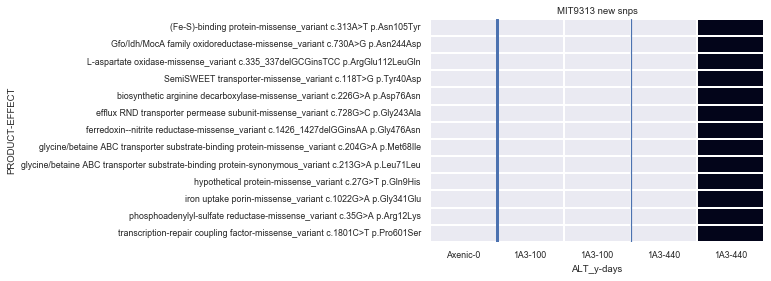

In [175]:
sns.set_context('paper')
#plt.figure(figsize=(5,20))
sns.heatmap(
    pdf.loc[~pdf.index.isin(pdf.dropna(subset=[('Axenic',  0)]).index)]
    ,linewidths=1, linecolor='white', cbar=False)
plt.axvline(1, lw=3)
plt.axvline(3)
plt.title(f'{species} new snps')

Text(0.5, 1, 'MIT9313 snps')

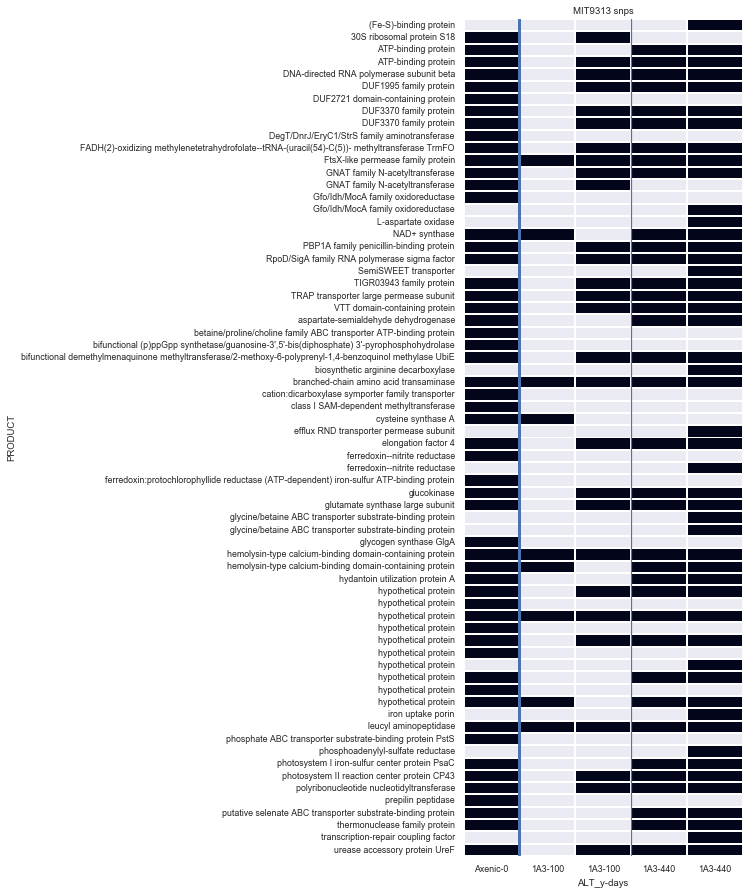

In [176]:
sns.set_context('paper')
plt.figure(figsize=(5,15))
sns.heatmap(pdf.droplevel(axis=0, level=1),linewidths=1, linecolor='white', cbar=False)
plt.axvline(1, lw=3)
plt.axvline(3)
plt.title(f'{species} snps')

In [177]:
species= 'MIT0604'
pdf = df.loc[df.species== species].pivot_table(
    index=['PRODUCT', 'LOCUS_TAG','EFFECT'
          ], columns=['ALT_y', 'days','sample', ],                                          
    aggfunc='count', margins=False, values=['TYPE'],
    margins_name='Total', #dropna=False, #fill_value=0,
).reindex(columns=['Axenic', '1A3', 'DE'], level='ALT_y', 
         ).droplevel(level=0, axis=1,  
         ).droplevel(level=2, axis=1, 
         ).droplevel(level=1, axis=0, 
         #).droplevel(level=1, axis=0, 
         ) 

In [178]:
pdf.shape

(14, 12)

Text(0.5, 1, 'MIT0604 new snps')

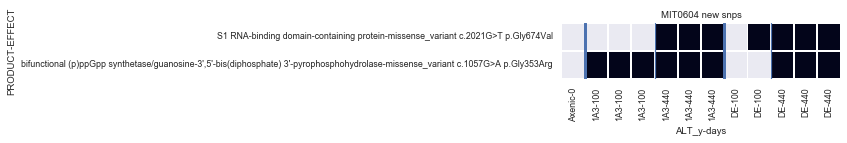

In [179]:
sns.set_context('paper')
plt.figure(figsize=(5,1))
sns.heatmap(
    pdf.loc[~pdf.index.isin(pdf.dropna(subset=[('Axenic',  0)]).index)]
    ,linewidths=1, linecolor='white', cbar=False)
plt.axvline(1, lw=3)
plt.axvline(4)
plt.axvline(7, lw=3)
plt.axvline(9)
plt.title(f'{species} new snps')

Text(0.5, 1, 'MIT0604 snps')

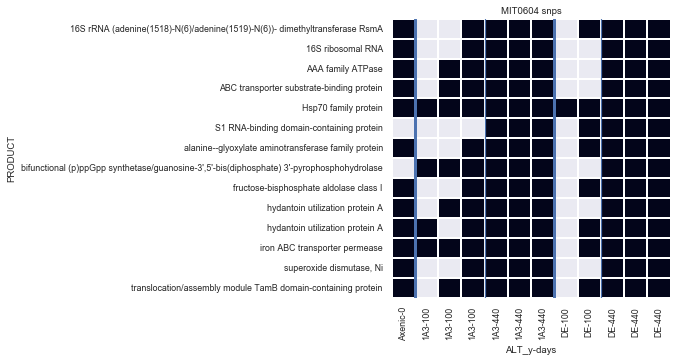

In [180]:
sns.set_context('paper')
plt.figure(figsize=(5,5))
sns.heatmap(pdf.droplevel(axis=0, level=1),linewidths=1, linecolor='white', cbar=False)
plt.axvline(1, lw=3)
plt.axvline(4)
plt.axvline(7, lw=3)
plt.axvline(9)
plt.title(f'{species} snps')

In [204]:
species= 'DE'
#df.loc[df.species== species].pivot_table(i)
pdf = df.loc[df.species== species].pivot_table(
    index=['PRODUCT', 'LOCUS_TAG','EFFECT'
          ], columns=['PRO', 'days','sample', ],                                          
    aggfunc='count', margins=False, values=['TYPE'],
    margins_name='Total', #dropna=False, #fill_value=0,
).reindex(columns=['Axenic', '9313', 'MIT0604'], level='PRO', 
         ).droplevel(level=0, axis=1,  
         ).droplevel(level=2, axis=1, 
         ).droplevel(level=1, axis=0, 
         #).droplevel(level=1, axis=0, 
         ) 

#sort_index(axis='columns', level='days')


In [212]:
species= 'DE'
#df.loc[df.species== species].pivot_table(i)
pdf = df.loc[df.species== species].pivot_table(
    index=['PRODUCT', 'LOCUS_TAG','EFFECT'
          ], columns=['PRO', 'days','sample', ],                                          
    aggfunc='count', margins=False, values=['TYPE'],
    margins_name='Total', #dropna=False, #fill_value=0,
         ) 

#sort_index(axis='columns', level='days')


In [215]:
df.loc[df.species.isin(['DE'])].groupby(['sample', 'days'])['TYPE'].count()

sample  days
10A     100      159
        440     1905
10B     100      117
10C     100     2485
Axenic  0        226
Name: TYPE, dtype: int64

In [213]:
pdf.head()

TYPE  \
PRO                                                                                                   Axenic   
days                                                                                                     0     
sample                                                                                                Axenic   
PRODUCT                                            LOCUS_TAG    EFFECT                                         
1-deoxy-D-xylulose-5-phosphate synthase            MADE_RS12700 synonymous_variant c.51T>C p.Pro17Pro    NaN   
                                                                synonymous_variant c.57G>A p.Lys19Lys    NaN   
                                                                synonymous_variant c.67C>T p.Leu23Leu    NaN   
                                                                synonymous_variant c.72T>C p.Pro24Pro    NaN   
16S rRNA (cytosine(1402)-N(4))-methyltransferas... MADE_RS14950 synonymous_variant c.27C>T p.His9His     NaN   

                                                                                                               \
PRO                                                                                                   MIT0604   
days                                                                                                      100   
sample                                                                                                    10A   
PRODUCT                                            LOCUS_TAG    EFFECT                                          
1-deoxy-D-xylulose-5-phosphate synthase            MADE_RS12700 synonymous_variant c.51T>C p.Pro17Pro     NaN   
                                                                synonymous_variant c.57G>A p.Lys19Lys     NaN   
                                                                synonymous_variant c.67C>T p.Leu23Leu     NaN   
                                                                synonymous_variant c.72T>C p.Pro24Pro     NaN   
16S rRNA (cytosine(1402)-N(4))-methyltransferas... MADE_RS14950 synonymous_variant c.27C>T p.His9His      NaN   

                                                                                                           \
PRO                                                                                                         
days                                                                                                        
sample                                                                                                10B   
PRODUCT                                            LOCUS_TAG    EFFECT                                      
1-deoxy-D-xylulose-5-phosphate synthase            MADE_RS12700 synonymous_variant c.51T>C p.Pro17Pro NaN   
                                                                synonymous_variant c.57G>A p.Lys19Lys NaN   
                                                                synonymous_variant c.67C>T p.Leu23Leu NaN   
                                                                synonymous_variant c.72T>C p.Pro24Pro NaN   
16S rRNA (cytosine(1402)-N(4))-methyltransferas... MADE_RS14950 synonymous_variant c.27C>T p.His9His  NaN   

                                                                                                            \
PRO                                                                                                          
days                                                                                                         
sample                                                                                                 10C   
PRODUCT                                            LOCUS_TAG    EFFECT                                       
1-deoxy-D-xylulose-5-phosphate synthase            MADE_RS12700 synonymous_variant c.51T>C p.Pro17Pro  1.0   
                                                                synonymous_variant c.57G>A p.Lys19Lys

In [206]:
pdf.shape

(4260, 5)

In [210]:
pdf.loc[~pdf.index.isin(pdf.dropna(subset=[('Axenic',  0)]).index)].shape


(4079, 5)

Text(0.5, 1, 'DE new snps')

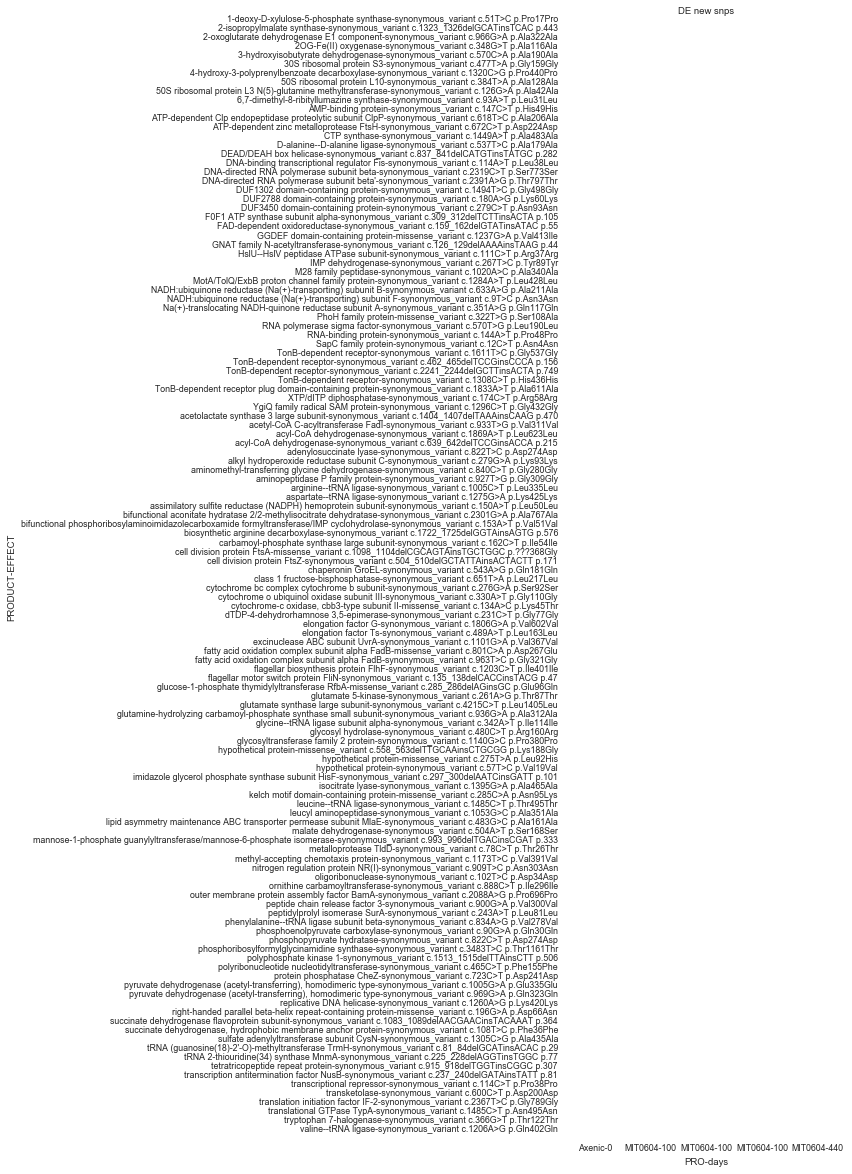

In [211]:
sns.set_context('paper')
plt.figure(figsize=(5,20))
sns.heatmap(
    pdf.loc[~pdf.index.isin(pdf.dropna(subset=[('Axenic',  0)]).index)]
    ,linewidths=1, linecolor='white', cbar=False)
#plt.axvline(1, lw=3)
#plt.axvline(3)
plt.title(f'{species} new snps')

Text(0.5, 1, '1A3 snps')

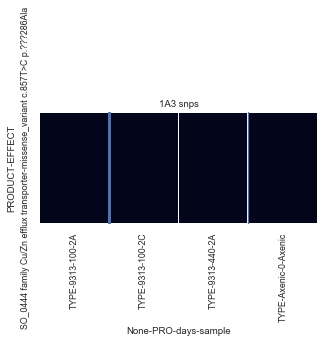

In [195]:
sns.set_context('paper')
plt.figure(figsize=(5,2))
sns.heatmap(pdf.droplevel(axis=0, level=1),linewidths=1, linecolor='white', cbar=False)
plt.axvline(1, lw=3)
plt.axvline(3)
plt.title(f'{species} snps')